In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
import cv2
import os 
import keras
from keras import layers, models
from tensorflow import keras as tfkeras
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm 

2024-06-09 20:59:37.037710: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 20:59:37.037857: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 20:59:37.169871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
image_size = 128
batch_size = 32
learn_rate = 0.01
epochs = 30
data_dir = "/kaggle/input/plantvillage-dataset/color"
input_folder = "/kaggle/input/plant-disease-test/test_images"
test_images = os.listdir("/kaggle/input/plant-disease-test/test_images")

In [3]:
def read_img(image_data):
    try:
        image = cv2.imread(image_data)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (image_size, image_size))
        image = np.array(image, dtype=np.float32) / 255.0  # Normalize the image
        image = image.reshape(1, image_size, image_size, 3)
        
        return image

    except Exception as e:
        print(f"Error> {e}")

In [4]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size,
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image_size, image_size),
    batch_size=batch_size,
)

Found 54305 files belonging to 38 classes.
Using 43444 files for training.
Found 54305 files belonging to 38 classes.
Using 10861 files for validation.


In [5]:
lencoder = LabelEncoder()

disease_classes = train_data.class_names

enc_classes = lencoder.fit_transform(disease_classes)

encoded_disease_classes = lencoder.classes_

print(encoded_disease_classes)

print(disease_classes)

enc_classes

['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___Target_Spot'
 'Tomato___Tom

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# data_augmentation = keras.models.Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(image_size,
#                                   image_size,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#   ]
# )

In [8]:
disease_clf = models.Sequential(
    [
        layers.Rescaling(1.0 / 255, input_shape=(image_size, image_size, 3)),
        layers.Conv2D(16, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(38, activation="softmax")
    ]
)

# disease_clf.compile(
#     optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
# )

disease_clf.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


disease_clf.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,766 (8.11 MB)

 Trainable params: 2,125,766 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
%%time

history = disease_clf.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:602: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-06-09 21:01:13.808825: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.3048, expected 3.51669
2024-06-09 21:01:13.808888: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.67675, expected 5.88864
2024-06-09 21:01:13.808904: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.43804, expected 5.64992
2024-06-09 21:01:13.808917: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.28496, expected 4.49684
2024-06-09 21:01:13.808927: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.70669, expected 4.91857
2024-06-09 21:

   9/1358 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.0279 - loss: 3.9184

I0000 00:00:1717966876.366959      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 447/1358 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.3598 - loss: 2.4478

2024-06-09 21:01:31.086666: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49152: 4.64678, expected 3.66233
2024-06-09 21:01:31.086729: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49153: 7.94017, expected 6.95573
2024-06-09 21:01:31.086739: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49154: 6.91143, expected 5.92698
2024-06-09 21:01:31.086747: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49155: 6.74267, expected 5.75822
2024-06-09 21:01:31.086754: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49156: 6.1315, expected 5.14705
2024-06-09 21:01:31.086762: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49157: 5.93105, expected 4.9466
2024-06-09 21:01:31.086770: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49158: 5.51288, expected 4.52843
2024-06-09 21:01:31.086778: E

1354/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5217 - loss: 1.7638

2024-06-09 21:01:58.748155: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16392: 3.49495, expected 3.04456
2024-06-09 21:01:58.748209: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16393: 3.13305, expected 2.68266
2024-06-09 21:01:58.748220: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16464: 2.93945, expected 2.48906
2024-06-09 21:01:58.748228: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 16465: 3.49857, expected 3.04818
2024-06-09 21:01:58.748248: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 18431: 3.01652, expected 2.56613
2024-06-09 21:01:58.748276: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 22272: 3.23573, expected 2.78534
2024-06-09 21:01:58.748290: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 23552: 3.32542, expected 2.87503
2024-06-09 21:01:58.748306:

1358/1358 ━━━━━━━━━━━━━━━━━━━━ 91s 32ms/step - accuracy: 0.5221 - loss: 1.7619 - val_accuracy: 0.7581 - val_loss: 0.8126
Epoch 2/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.7781 - loss: 0.7606 - val_accuracy: 0.8012 - val_loss: 0.6911
Epoch 3/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8438 - loss: 0.5316 - val_accuracy: 0.8089 - val_loss: 0.7403
Epoch 4/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8335 - loss: 0.6246 - val_accuracy: 0.8132 - val_loss: 0.7417
Epoch 5/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8590 - loss: 0.5435 - val_accuracy: 0.8239 - val_loss: 0.8658
Epoch 6/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8703 - loss: 0.4997 - val_accuracy: 0.8364 - val_loss: 0.7444
Epoch 7/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8583 - loss: 0.5742 - val_accuracy: 0.8357 - val_loss: 0.7607
Epoch 8/30
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8463 - loss: 0.6629 - val_accu

In [10]:
test_accuracy = disease_clf.evaluate(val_data, batch_size=batch_size)

print(
    f"The trained plant leaf disease detection model has an accuracy of {100*test_accuracy[1]:.2f}%"
)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6762 - loss: 1.8495
The trained plant leaf disease detection model has an accuracy of 68.07%


In [11]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

Text(0.5, 1.0, 'Training and Validation Accuracy')

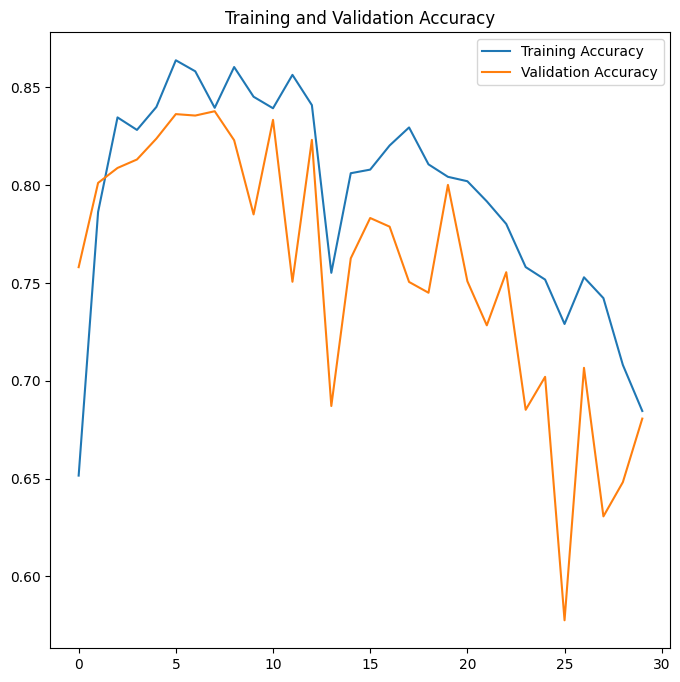

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="upper right")
plt.title("Training and Validation Accuracy")

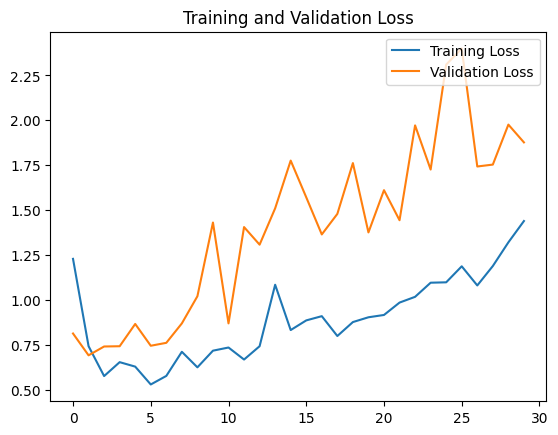

In [13]:
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [14]:
image_list = [os.path.join(input_folder, image_file) for image_file in test_images]

def detect_plant_disease(image: str):
    image = read_img(image)
    class_score = disease_clf.predict(image)
    
    predicted_class = np.argmax(class_score)
    certainty = 100 * np.max(class_score)
    
    return predicted_class, certainty
    
    
for image in tqdm(image_list):
    disease_class, certainty = detect_plant_disease(image)
    print('_' * 80)
    print(f'Input Sentence: {image}')
    print(f'Predicted: {encoded_disease_classes[disease_class]}')
    print(f'or: {disease_classes[disease_class]}')
    print(f'Certainty: {certainty:.2f}%')
    print(' ')
    print('_'* 80)

  0%|          | 0/7 [00:00<?, ?it/s]

2024-06-09 21:06:02.382966: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.35916, expected 3.62506
2024-06-09 21:06:02.383017: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.14279, expected 5.4087
2024-06-09 21:06:02.383037: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.55453, expected 4.82044
2024-06-09 21:06:02.383045: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.08747, expected 4.35338
2024-06-09 21:06:02.383052: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 3.96432, expected 3.23023
2024-06-09 21:06:02.383060: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 3.84695, expected 3.11286
2024-06-09 21:06:02.383067: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.1695, expected 4.43541
2024-06-09 21:06:02.383075: E external/local_xla/xla/serv

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
________________________________________________________________________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/apple_healthy.jpeg
Predicted: Tomato___Late_blight
or: Tomato___Late_blight
Certainty: 100.00%
 
________________________________________________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
________________________________________________________________________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/healthy_tomato_leaf.jpeg
Predicted: Tomato___Late_blight
or: Tomato___Late_blight
Certainty: 100.00%
 
________________________________________________________________________________
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
________________________________________________________________________________
Input Sentence: /kaggle/input/plant-disease-test/test_images/cornleafnormal.jpeg
Predicted: Tomato___Late_blight
or: Tomato___Late_blight
Certainty: 100.00%
 

In [15]:
def predict2(img_file):
    img = tf.keras.utils.load_img(img_file, target_size=(image_size, image_size))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = disease_clf.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
    "This image {} most likely belongs to \n {} ."
    .format(img_file, disease_classes[np.argmax(score)])
    )
    
for image in tqdm(image_list):
    predict2(image)

  0%|          | 0/7 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
This image /kaggle/input/plant-disease-test/test_images/apple_healthy.jpeg most likely belongs to 
 Corn_(maize)___healthy .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image /kaggle/input/plant-disease-test/test_images/healthy_tomato_leaf.jpeg most likely belongs to 
 Tomato___Late_blight .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
This image /kaggle/input/plant-disease-test/test_images/cornleafnormal.jpeg most likely belongs to 
 Corn_(maize)___healthy .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image /kaggle/input/plant-disease-test/test_images/tomato_leafdiseas.jpeg most likely belongs to 
 Corn_(maize)___Common_rust_ .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
This image /kaggle/input/plant-disease-test/test_images/leafrustcorn.jpeg most likely belongs to 
 Corn_(maize)___Common_rust_ .
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
This image /kaggle/input/plant-disease-test/test_images/corn_leafdiseased.jpeg most likely belongs to 
 Corn_(maize)___healthy .


In [16]:
disease_clf.save("tf_plant_disease_classifier.keras")
disease_clf.save("tf_plant_disease_classifier.h5")

In [17]:
# import tensorflow as tf

# outfile = '/kaggle/working/leaf_disease_clf.tflite'

# converter = tf.lite.TFLiteConverter.from_keras_model(disease_clf)
# tflite_model = converter.convert()

# # Save the model.
# with open(outfile, 'wb') as f:
#     f.write(tflite_model)